In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA 
from sklearn.feature_selection import (RFE, SelectKBest, 
                                       SelectPercentile,RFECV)

In [3]:
df = pd.read_csv('data/Train_Data.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0


In [4]:
df2 = pd.read_csv('data/Traindata_classlabels.csv')
df2.head()

,price_range
0,1
1,2
2,2
3,2
4,1


In [5]:
data = {}
data_GS = {}

In [6]:
def Classification(X_train, X_test, y_train, y_test,data,name:str,Gridsearch = False):
    try:
        y_train = y_train.values.ravel()
        y_test = y_test.values.ravel()
    except:
        pass
    
    classifiers = [
    KNeighborsClassifier(),
    LogisticRegression()
    ]
    if Gridsearch ==True:
        clf_parameters = [
            {
                "clf__n_neighbors": np.arange(2,25 ,1),
                "clf__metric": ["cityblock","cosine","euclidean","l1","l2","manhattan","nan_euclidean",],
                "clf__weights": ["uniform", "distance"],
                "clf__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
         },
        {
                "clf__C": np.logspace(-2, -1.5, 30),
                "clf__penalty": ["l1", "l2", "elasticnet", "none"],
                "clf__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        }
         ]
    else:
        clf_parameters = [{},{}]
    data[name] = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    dataint = {'Model':[],'Accuracy' :[],'f1_micro' :[],'f1_macro' :[]}
    
    i=1
    for classifier,clf_params in zip(classifiers,clf_parameters):
        pipe = Pipeline(steps=[('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=10,n_jobs=-1)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i+=1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
    classifiers = [
        DecisionTreeClassifier(),    
        SVC(), 
        NuSVC(),
        RandomForestClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        SGDClassifier()
        ]
    base_estimators = classifiers
    if Gridsearch==True:
        clf_parameters = [
                          {
                'clf__criterion' : ["gini", "entropy"], 
            'clf__max_features':['sqrt', 'log2',None],
        #             'max_depth':np.linspace(140,190,10),
                    'clf__ccp_alpha':np.logspace(-3,-2,20),#np.logspace(-2.32,-2.3,20),
            "clf__max_leaf_nodes" : [None]+np.arange(30,40,5).tolist(),

            "clf__splitter" : ["best", "random"],
            "clf__min_samples_split":np.arange(2,50,10)
        },


            {
                    'clf__C':(0.8,2,30),
                    'clf__kernel':('linear','rbf','poly','sigmoid'),
                    'clf__decision_function_shape' : ['ovo', 'ovr'],
                    'clf__degree':np.arange(3,5,1)
                    },
            {
                'clf__nu': np.logspace(-1.15,-1.23,5),#np.logspace(-2,-1,30)
             'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid' ]   ,
                'clf__gamma' : ['scale', 'auto'],
                'clf__degree':np.arange(3,5,1),
                'clf__decision_function_shape' : ['ovo', 'ovr'],
            },
            {
                 'clf__n_estimators': [150,200,250],
            'clf__max_features': ['sqrt', 'log2',None],
            'clf__max_depth' : [None],#np.arange(4,15,2).tolist(),
            'clf__criterion' :['gini', 'entropy']   ,
                'clf__bootstrap' :[True],
        #         'clf__ccp_alpha':np.logspace(-2,1,10)
            },
            {
                'clf__base_estimator':[RandomForestClassifier(),DecisionTreeClassifier(criterion='entropy'),SVC(),LogisticRegression(**{'C': 0.017433288221999882, 'penalty': 'l2', 'solver': 'newton-cg'})],
                'clf__algorithm' : ['SAMME', 'SAMME.R'],
                'clf__n_estimators': [50,100]
            },
            {
              'clf__loss' :['deviance', 'exponential'],
                'clf__criterion' : ['friedman_mse', 'squared_error'],
                'clf__max_features' : [ 'sqrt', 'log2'],
                'clf__learning_rate': np.logspace(-1,1,5),
                'clf__n_estimators':np.arange(100,1000,200)

            },
            {
                'clf__loss' :['hinge', 'log', 'modified_huber','squared_hinge', 'perceptron'],
                'clf__penalty' : ['l2', 'l1', 'elasticnet'], 
                'clf__alpha' : np.logspace(-4,-2,30),
                'clf__learning_rate' :[ 'constant','optimal','invscaling','adaptive'],
            }
            ]
    else:
        clf_parameters = [{}]*len(classifiers)
    for classifier,clf_params in zip(classifiers,clf_parameters):
        pipe = Pipeline(steps=[('standardscaler', StandardScaler()),('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=10,n_jobs=-1)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i=i+1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
    
    
    classifiers = [
    GaussianNB(),
    MultinomialNB()
    ]
    if Gridsearch==True:
        clf_parameters = [
            {
            'clf__var_smoothing':np.logspace(-20,-10,10)
            },
            {
                'clf__alpha':[0] + np.logspace(-2,5,5).tolist(),
                'clf__fit_prior':[True,False]
            }
             ]
    else:
        clf_parameters = [{}]*len(classifiers)

    for classifier,clf_params in zip(classifiers,clf_parameters):
        pipe = Pipeline(steps=[('minmaxscalar',MinMaxScaler()),('clf', classifier)])
        grid = GridSearchCV(pipe,clf_params,scoring='f1_macro',cv=10,n_jobs=-1)  
        try:
            grid.fit(X_train, y_train)   
            pred = grid.predict(X_test)
            print("_"*32)
            print(f'{i}.',classifier)
            print("_"*32)
            print(grid.best_params_)
            print(classification_report(y_test, pred))
            i=i+1
            i1 = classifier.__class__.__name__
            i2 = sklearn.metrics.accuracy_score(y_test,pred)
            i3 = sklearn.metrics.f1_score(y_test,pred,average='micro')
            i4 = sklearn.metrics.f1_score(y_test,pred,average='macro')
            dataint['Model'].append(i1)
            dataint['Accuracy'].append(i2)
            dataint['f1_micro'].append(i3)
            dataint['f1_macro'].append(i4)
            print("-"*80)
            print("-"*80)
            
        except Exception as e: print(e)
            
    data[name] = dataint
#     print(dataint)


# With and Without Grid Search

## Raw data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df,df2,random_state=5,shuffle=True,test_size=0.2)
Classification(X_train, X_test, y_train, y_test,data,'Raw')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train, X_test, y_train, y_test,data_GS,'Raw_GS',Gridsearch=True)

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       103
           1       0.88      0.92      0.90        92
           2       0.88      0.87      0.88       101
           3       0.97      0.91      0.94       104

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       103
           1       0.60      0.60      0.60        92
           2       0.49      0.46      0.47       10

## Feature Engineering

In [8]:
# df4.drop('four_g',axis = 1,inplace=True)
df4 = df.copy()
df4['sc_diag'] = np.sqrt(df['sc_h']**2 + df['sc_w']**2)
df4['sc_area'] = df['sc_h'] * df['sc_w']
df4['px_diag'] = np.sqrt(df['px_height']**2 + df['px_width']**2)
df4['px_area'] = df['px_width'] * df['px_height']
df4['talk_per_mAh'] = df['talk_time']/ df['battery_power']
df4['connectivity'] = df['three_g'] + df['four_g'] + df['blue'] + df['wifi'] + df['dual_sim']
df4['ram_per_core'] = df['ram'] / df['n_cores']
df4['weight_by_thickness'] = df['mobile_wt'] / df['m_dep']
df4['total_clock_speed'] = df['clock_speed'] * df['n_cores']
df4['fc_res'] = [1 if df['fc'][i] >=8 else 0 for i in range(len(df)) ]
df4['pc_res'] = [1 if df['pc'][i] >=8 else 0 for i in range(len(df)) ]
df4['sc_res'] = [1 if( df['px_width'][i] * df['px_height'][i] ) >= 921600 else 0 for i in range(len(df)) ]
df4['DPIx'] = df['px_width'] / (df['sc_w']*0.394 + 1)
df4['DPIy'] = df['px_height'] / (df['sc_h']*0.394 + 1)
df4['DPI'] = (df['px_width'] * df['px_height']) / (df4['sc_area'] * (0.394)**2 + 1)
df4
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(df4,df2,random_state=5,shuffle=True,test_size=0.2)

## After Feature Engineering

In [9]:
Classification(X_train_e, X_test_e, y_train_e, y_test_e,data,'Feature_eng')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_e, X_test_e, y_train_e, y_test_e,data_GS,'Feature_eng_GS',Gridsearch=True)

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       103
           1       0.26      0.27      0.27        92
           2       0.24      0.23      0.24       101
           3       0.29      0.20      0.24       104

    accuracy                           0.29       400
   macro avg       0.28      0.29      0.28       400
weighted avg       0.28      0.29      0.28       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       103
           1       0.42      0.58      0.48        92
           2       0.32      0.24      0.27       10

## Feature Selection

### Correlation

clock_speed
m_dep
n_cores
weight_by_thickness
total_clock_speed
pc_res


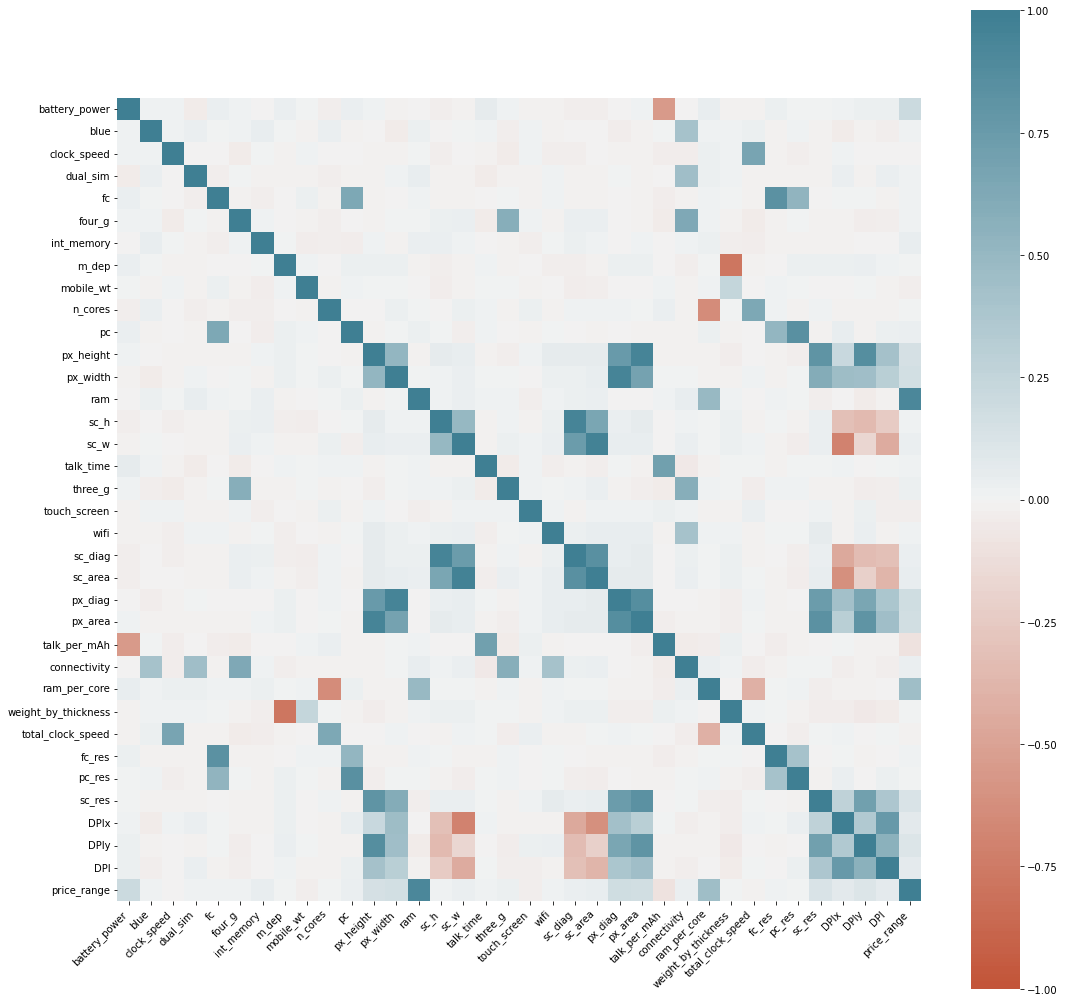

In [10]:
df5 = df4.copy()
df5['price_range'] = df2 
corr = df5.corr()
plt.figure(figsize = (18,18))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
d = 0.01
col = []
for idx,i in enumerate(corr['price_range']):
    if i <= d and i >= -d:
        col.append(corr.columns[idx])
        print(corr.columns[idx])
df5 = df5.drop(col,axis = 1)
df5 = df5.drop('price_range',axis = 1)
df5
X_train_ec, X_test_ec, y_train_ec, y_test_ec = train_test_split(df5,df2,random_state=5,shuffle=True,test_size=0.2)

### After Feature Engg + Correlation

In [11]:
Classification(X_train_ec, X_test_ec, y_train_ec, y_test_ec,data,'Feature_engg + Corr')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_ec, X_test_ec, y_train_ec, y_test_ec,data_GS,'Feature_engg + Corr_GS',Gridsearch=True)

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       103
           1       0.26      0.27      0.27        92
           2       0.25      0.24      0.24       101
           3       0.30      0.20      0.24       104

    accuracy                           0.29       400
   macro avg       0.29      0.29      0.28       400
weighted avg       0.29      0.29      0.28       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.92      0.67      0.78       103
           1       0.40      0.63      0.49        92
           2       0.35      0.14      0.20       10

### Variance Inflation Factor

In [12]:
scalar = StandardScaler()
X_tranform = scalar.fit_transform(df5)
df6 = pd.DataFrame(X_tranform,columns=df5.columns)
df6
vif = [variance_inflation_factor(df6.values,i) for i in range(df6.shape[1])]
d = 5 # Threshold for Variance Inflation, 
col = []
for idx,i in enumerate(vif):
    if i >= d:
        col.append(df6.columns[idx])
        print(df6.columns[idx])
df6  = df6.drop(col,axis = 1)
X_train_ecv, X_test_ecv, y_train_ecv, y_test_ecv = train_test_split(df6,df2,random_state=5,shuffle=True,test_size=0.2)

blue
dual_sim
four_g
px_height
px_width
sc_h
sc_w
talk_time
three_g
wifi
sc_diag
sc_area
px_diag
px_area
talk_per_mAh
connectivity
DPIx
DPIy


In [13]:
Classification(X_train_ecv, X_test_ecv, y_train_ecv, y_test_ecv,data,'Engg+corr+VIF')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_ecv, X_test_ecv, y_train_ecv, y_test_ecv,data_GS,'Engg+corr+VIF_GS',Gridsearch=True)

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       103
           1       0.57      0.66      0.61        92
           2       0.59      0.57      0.58       101
           3       0.84      0.71      0.77       104

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       103
           1       0.85      0.84      0.84        92
           2       0.84      0.83      0.84       10

## PCA

### On Raw data

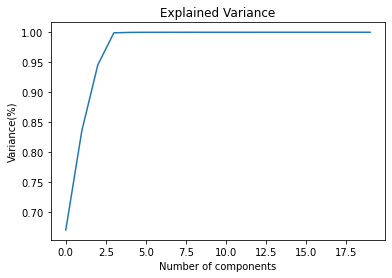

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       103
           1       0.88      0.92      0.90        92
           2       0.89      0.87      0.88       101
           3       0.97      0.92      0.95       104

    accuracy                           0.93       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.93      0.93      0.93       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       103
           1       0.94      0.95      0.94        92
           2       0.95      0.93      0.94       10

In [14]:
pca = PCA()
principalComp = pca.fit_transform(df)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance(%)')
plt.title('Explained Variance')
plt.show()
n_components=4
pca = PCA(n_components=n_components)
new_data = pca.fit_transform(df)
df7 = pd.DataFrame(new_data,columns = [f'column {i}' for i in range(n_components)])
df7
X_train, X_test, y_train, y_test = train_test_split(df7,df2,random_state=5,shuffle=True,test_size=0.2)
Classification(X_train, X_test, y_train, y_test,data,'PCA_raw')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train, X_test, y_train, y_test,data_GS,'PCA_raw_GS',Gridsearch=True)

### On df6(After VIF)

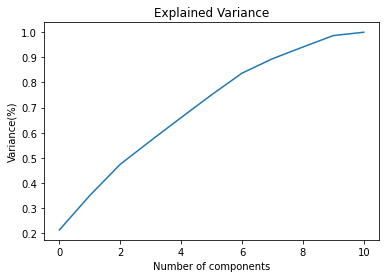

________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       103
           1       0.56      0.70      0.62        92
           2       0.60      0.58      0.59       101
           3       0.85      0.74      0.79       104

    accuracy                           0.71       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.72      0.71      0.71       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       103
           1       0.83      0.82      0.82        92
           2       0.83      0.83      0.83       10

In [15]:
pca = PCA()
principalComp = pca.fit_transform(df6)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance(%)')
plt.title('Explained Variance')
plt.show()
n_components=10
pca = PCA(n_components=n_components)
new_data = pca.fit_transform(df6)
df7 = pd.DataFrame(new_data,columns = [f'column {i}' for i in range(n_components)])
df7
X_train_ecvp, X_test_ecvp, y_train_ecvp, y_test_ecvp = train_test_split(df7,df2,random_state=5,shuffle=True,test_size=0.2)
Classification(X_train_ecvp, X_test_ecvp, y_train_ecvp, y_test_ecvp.values.ravel(),data,'PCA_e+c+v')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_ecvp, X_test_ecvp, y_train_ecvp, y_test_ecvp.values.ravel(),data_GS,'PCA_e+c+v_GS',Gridsearch=True)

## Reverse Feature Elimination

In [17]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(df4,df2,random_state=5,shuffle=True,test_size=0.2)

In [18]:
rfe = RFE(GradientBoostingClassifier(random_state=42), 
          n_features_to_select=10)
rfe.fit(X_train_e, y_train_e.values.ravel())
rfe_features = X_train_e.columns[rfe.support_]
dfr = df4[rfe_features]
print(f"===== {len(rfe_features)} features were selected =====")
print(f"{', '.join(rfe_features)}")
X_train_er, X_test_er, y_train_er, y_test_er = train_test_split(dfr,df2,random_state=5,shuffle=True,test_size=0.2)

Classification(X_train_er, X_test_er, y_train_er, y_test_er,data,'RFE_e')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_er, X_test_er, y_train_er, y_test_er,data_GS,'RFE_e_GS',Gridsearch=True)

===== 10 features were selected =====
battery_power, mobile_wt, px_height, px_width, ram, px_diag, px_area, talk_per_mAh, ram_per_core, weight_by_thickness
________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.43      0.50      0.47       103
           1       0.24      0.33      0.28        92
           2       0.30      0.28      0.29       101
           3       0.30      0.17      0.22       104

    accuracy                           0.32       400
   macro avg       0.32      0.32      0.31       400
weighted avg       0.32      0.32      0.31       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

    

## Reverse Feature Elimination with CV

In [19]:
rfecv = RFECV(GradientBoostingClassifier(random_state=42), 
          min_features_to_select=10,cv=10,n_jobs=-1)
rfecv.fit(X_train_e, y_train_e.values.ravel())
rfecv_features = X_train_e.columns[rfe.support_]
dfrv = df4[rfecv_features]
print(f"===== {len(rfecv_features)} features were selected =====")
print(f"{', '.join(rfecv_features)}")
X_train_er, X_test_er, y_train_er, y_test_er = train_test_split(dfrv,df2,random_state=5,shuffle=True,test_size=0.2)

Classification(X_train_er, X_test_er, y_train_er, y_test_er,data,'RFECV_e')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_er, X_test_er, y_train_er, y_test_er,data_GS,'RFECV_e_GS',Gridsearch=True)

===== 10 features were selected =====
battery_power, mobile_wt, px_height, px_width, ram, px_diag, px_area, talk_per_mAh, ram_per_core, weight_by_thickness
________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.43      0.50      0.47       103
           1       0.24      0.33      0.28        92
           2       0.30      0.28      0.29       101
           3       0.30      0.17      0.22       104

    accuracy                           0.32       400
   macro avg       0.32      0.32      0.31       400
weighted avg       0.32      0.32      0.31       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

    

## SelectKBest

In [20]:
kbest = SelectKBest(k=10)
kbest.fit(X_train_e, y_train_e.values.ravel())
# See selected features
kbest_features = X_train_e.columns[kbest.get_support()]
dfk = df4[kbest_features]
print(f"===== {len(kbest_features)} features were selected =====")
print(f"{', '.join(kbest_features)}")
X_train_ek, X_test_ek, y_train_ek, y_test_ek = train_test_split(dfk,df2,random_state=5,shuffle=True,test_size=0.2)

Classification(X_train_ek, X_test_ek, y_train_ek, y_test_ek,data,'KBest_e')
print('WITH GridSearch'+'\n'+"-"*80+'\n'+"-"*80 )
Classification(X_train_ek, X_test_ek, y_train_ek, y_test_ek,data_GS,'KBest_e_GS',Gridsearch=True)

===== 10 features were selected =====
battery_power, px_height, px_width, ram, px_diag, px_area, talk_per_mAh, ram_per_core, sc_res, DPIy
________________________________
1. KNeighborsClassifier()
________________________________
{}
              precision    recall  f1-score   support

           0       0.45      0.53      0.49       103
           1       0.23      0.32      0.27        92
           2       0.30      0.28      0.29       101
           3       0.30      0.17      0.22       104

    accuracy                           0.33       400
   macro avg       0.32      0.32      0.32       400
weighted avg       0.32      0.33      0.32       400

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
________________________________
2. LogisticRegression()
________________________________
{}
              precision    recall  f1-score   support

           0       0.9

In [21]:
pd.DataFrame(data).to_csv('data.csv')
pd.DataFrame(data_GS).to_csv('data_GS.csv')

## Predicting Final Results

Using Logistic Regression with params = {'clf__C': 0.02807216203941177, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


In [7]:
df = pd.read_csv('data/Train_Data.csv')
df.head()
df2 = pd.read_csv('data/Traindata_classlabels.csv')
df2.head()
params = {'C': 0.02807216203941177, 'penalty': 'l2', 'solver': 'newton-cg'}

model = LogisticRegression(**params)
X_train, X_test, y_train, y_test = train_test_split(df,df2,random_state=5,shuffle=True,test_size=0.2)
model.fit(X_train,y_train)
pred_val = model.predict(X_test)
print(classification_report(y_test,pred_val))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.98      0.99      0.98        92
           2       0.98      0.98      0.98       101
           3       0.99      0.99      0.99       104

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



### Predicting test labels

In [8]:
df_test = pd.read_csv('data/testdata.csv')
df_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [11]:
predictions = model.predict(df_test)
np.savetxt("Alli_KhadgaJyoth_testdata_classlabels.txt",predictions , delimiter="\n", fmt="%.0f")